# Agent Based Models

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import three_frame

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [3]:
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

In [4]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

In [5]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

try:
    import inequality_coefficients
except ImportError:
    %pip install inequality_coefficients

## Sugarscape

Most base functions for the Sugarscape model are [Think Complexity, 2nd edition](https://thinkcomplex.com). 
Have commented where it is custom code for this assignment. 

In [6]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.

    n: int number of rows
    m: int number of cols

    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

In [7]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.

    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a

    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [8]:
def distances_from(n, i, j):
    """Computes an array of distances.

    n: size of the array
    i, j: coordinates to find distance from

    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

In [9]:
# Code from https://github.com/oliviaguest/gini
def gini_coefficient(array):
    """Calculate the Gini coefficient of a list."""
    # Convert list to numpy array
    array = np.array(array)

    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm

    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    array = array + 0.000000000000001
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]

    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


In [10]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# make a custom color map
palette = sns.color_palette('deep')
colors = 'white', palette[1], palette[0]
diverge_colors = ['firebrick', 'white', 'cadetblue']
cmap = LinearSegmentedColormap.from_list('cmap', colors)
diverge_cmap = LinearSegmentedColormap.from_list('custom_coolwarm', diverge_colors)


In [11]:
# Customised Sugarscape class
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""

    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        self.step_count = 0  # Step counter to manage welfare distribution
        self.dead_agents = []  # Track agents that have died

        # track variables
        self.agent_count_seq = []
        self.welfare_eligible_seq = []  # Number of welfare-eligible agents
        self.disabled_count_seq = []  # Track disabled agents
        self.non_disabled_count_seq = []  # Track non-disabled agents
        self.gini_seq = [] # Track Gini coefficient
        self.total_welfare_given = []  # Track welfare given at each step
        self.total_resources = []  # Track total resources in the environment

        # make the capacity array
        self.capacity = self.make_capacity()


        # initially all cells are at capacity
        self.array = self.capacity.copy()

        # make the agents
        self.make_agents()

    def make_capacity(self):
        """Makes the capacity array."""

        # compute the distance of each cell from the peaks.
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)

        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a

    def make_agents(self):
        """Makes the agents."""

        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params)
                        for i in range(num_agents)]

        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)

    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array += grow_rate
        self.array = np.minimum(self.array, self.capacity)

    def welfare_distribution(self):
        """Distribute welfare to eligible agents."""
        if self.step_count % self.params.get('welfare_timestep', 5) == 0:  # Only distribute welfare every 5 steps
            welfare_amount = self.params.get('welfare_amount', 1)
            total_welfare = 0
            for agent in self.agents:
                if agent.welfare_eligible:
                    agent.receive_welfare(welfare_amount)
                    total_welfare += welfare_amount
            self.total_welfare_given.append(total_welfare)

    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.

        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance

        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n

        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]

        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]

        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center

        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]

        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]

    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.

        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar

    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        self.step_count += 1

        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:

            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)

            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.dead_agents.append(agent.get_state())
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # Update Gini coefficient
        if self.agents:
            wealth = [agent.sugar for agent in self.agents]
            self.gini_seq.append(gini_coefficient(wealth))
        else:
            self.gini_seq.append(0)  # No inequality if no agents are left

        # Welfare distribution
        self.welfare_distribution()

        # grow back some sugar
        self.grow()

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        self.welfare_eligible_seq.append(sum(1 for agent in self.agents if agent.welfare_eligible))
        self.disabled_count_seq.append(sum(1 for agent in self.agents if agent.disability))
        self.non_disabled_count_seq.append(sum(1 for agent in self.agents if not agent.disability))

        self.total_resources.append(np.sum(self.array))

        return len(self.agents)

    def add_agent(self):
        """Generates a new random agent.

        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent

    def random_loc(self):
        """Choose a random unoccupied cell.

        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap=cmap, vmin= 1, vmax=12, origin='lower')

        # Separate disabled and non-disabled agents
        disabled_agents = [agent for agent in self.agents if agent.disability]
        eligible_agents = [agent for agent in self.agents if agent.welfare_eligible and not agent.disability]
        other_agents = [agent for agent in self.agents if not agent.welfare_eligible and not agent.disability]

        # Plot agents
        if other_agents:
            rows, cols = np.transpose([agent.loc for agent in other_agents])
            plt.plot(cols + 0.5, rows + 0.5, '.', color='tomato', label="Non-Disabled, Not Eligible")

        if disabled_agents:
            rows, cols = np.transpose([agent.loc for agent in disabled_agents])
            plt.plot(cols + 0.5, rows + 0.5, '.', color='cadetblue', label="Disabled Agents")

        if eligible_agents:
            rows, cols = np.transpose([agent.loc for agent in eligible_agents])
            plt.plot(cols + 0.5, rows + 0.5, '.', color='yellowgreen', label="Welfare Eligible")

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True)

    def get_dead_agents(self):
        """Returns the list of dead agents."""
        return self.dead_agents

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

Here's my implementation of the agents.

In [12]:
# Customised Agent class
class Agent:

    def __init__(self, loc, params):
        """Creates a new agent at the given location.

        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        total_agents = params.get('num_agents', 400)

        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

        # Disability and welfare eligibility
        num_disabled = int(0.16 * total_agents)
        self.disability = np.random.choice([True, False], p=[num_disabled / total_agents, 1 - num_disabled / total_agents])
        self.welfare_eligible = self.disability or (self.sugar < (min_sugar + 2))
        self.welfare_count = 0

        if self.disability:
            self.vision = max(1, self.vision - 2)
            self.metabolism *= 1.5

    def step(self, env):
        """Look around, move, and harvest.

        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1
        self.update_welfare_eligibility(env.params)

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0

    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

    def get_state(self):
        """Returns a dictionary of the agent's current state."""
        return {
            'Location': self.loc,
            'Age': self.age,
            'Vision': self.vision,
            'Metabolism': self.metabolism,
            'Sugar': self.sugar,
            'Disability': self.disability,
            'Welfare Eligible': self.welfare_eligible,
            'Welfare Count': self.welfare_count,
        }

    def receive_welfare(self, amount):
        """Track welfare received."""
        self.sugar += amount
        self.welfare_count += 1

    def update_welfare_eligibility(self, params):
        """Update welfare eligibility dynamically."""
        min_sugar = params.get('min_sugar', 5)
        self.welfare_eligible = self.disability or (self.sugar < (min_sugar + 2))

Here's an example with `n=50`, starting with 400 agents.

In [13]:
# Parameters

n = 50
num_agents = 400
timesteps = 100
welfare_amount = 1
welfare_timestep = 5

Saving figure to file figs/sugarscape-initial


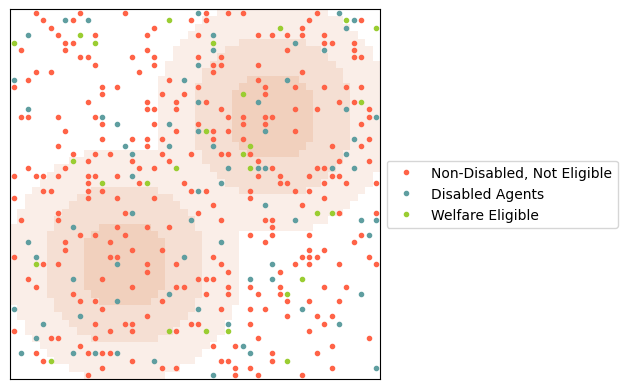

In [14]:
env = Sugarscape(n, num_agents=num_agents, welfare_amount=welfare_amount, welfare_timestep=welfare_timestep)
env.draw()

savefig('figs/sugarscape-initial', bbox_inches='tight', pad_inches=0.1)

Saving figure to file figs/sugarscape-step


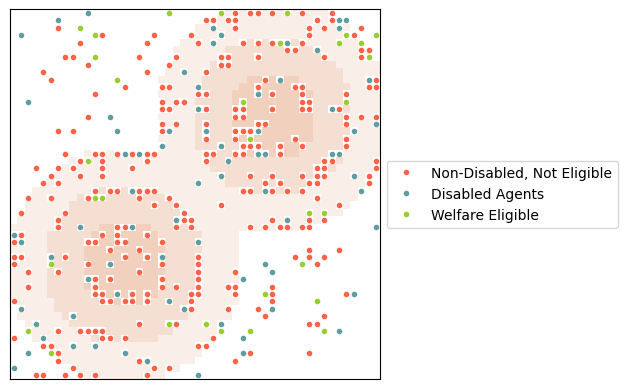

In [15]:
env.step()
env.draw()
savefig('figs/sugarscape-step', bbox_inches='tight', pad_inches=0.1)

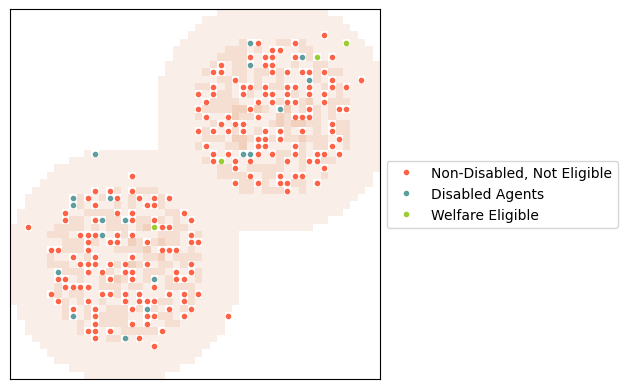

In [16]:
env.animate(frames=timesteps)

# Analysis

All this code is original for this assignment.

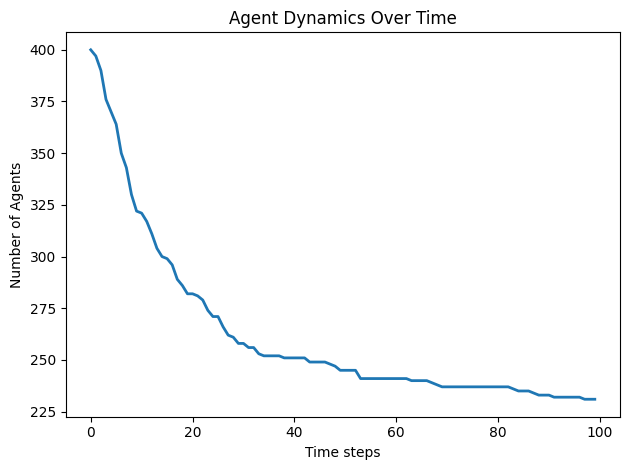

In [17]:
plt.plot(env.agent_count_seq)
plt.title('Agent Dynamics Over Time')
decorate(xlabel='Time steps', ylabel='Number of Agents')
plt.show()

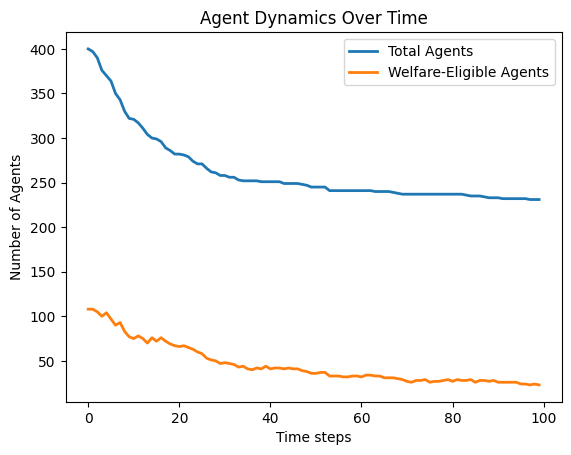

In [18]:
plt.plot(env.agent_count_seq, label='Total Agents')
plt.plot(env.welfare_eligible_seq, label='Welfare-Eligible Agents')
plt.xlabel('Time steps')
plt.ylabel('Number of Agents')
plt.legend()
plt.title('Agent Dynamics Over Time')
plt.show()

In [19]:
from IPython.display import display

dead_agents_data = env.dead_agents
if dead_agents_data:
    df = pd.DataFrame(dead_agents_data)
    display(df.style.set_table_attributes('style="max-height:300px; display:block; overflow:auto;"'))
else:
    print("No agents have died yet.")

,Location,Age,Vision,Metabolism,Sugar,Disability,Welfare Eligible,Welfare Count
0,"(np.int64(3), np.int64(11))",2,1,5.885363,-1.033647,True,True,0
1,"(np.int64(15), np.int64(35))",2,3,5.610567,-2.883183,True,True,0
2,"(np.int64(5), np.int64(30))",2,1,5.809380,-4.171333,True,True,0
3,"(np.int64(5), np.int64(43))",3,1,3.004657,-1.699940,False,True,0
4,"(np.int64(12), np.int64(45))",3,1,2.831713,-0.997922,True,True,0
5,"(np.int64(15), np.int64(32))",3,2,3.583757,-0.911857,True,True,0
6,"(np.int64(39), np.int64(15))",3,1,2.998517,-0.173537,False,True,0
7,"(np.int64(45), np.int64(11))",3,3,3.654894,-0.251762,False,True,0
8,"(np.int64(0), np.int64(9))",3,2,2.517665,-0.957401,False,True,0
9,"(np.int64(33), np.int64(48))",3,3,5.476906,-2.230601,True,True,0


In [20]:
final_agents_df = pd.DataFrame([agent.get_state() for agent in env.agents])
display(final_agents_df.style.set_table_attributes('style="max-height:300px; display:block; overflow:auto;"'))

,Location,Age,Vision,Metabolism,Sugar,Disability,Welfare Eligible,Welfare Count
0,"(np.int64(35), np.int64(26))",100,1,1.897781,91.120990,False,False,0
1,"(np.int64(41), np.int64(40))",100,1,2.155153,47.290130,False,False,0
2,"(np.int64(45), np.int64(38))",100,3,1.654816,153.951771,False,False,0
3,"(np.int64(14), np.int64(24))",100,5,2.458249,59.199080,False,False,0
4,"(np.int64(35), np.int64(39))",100,3,1.353691,164.491310,False,False,0
5,"(np.int64(17), np.int64(6))",100,6,1.525597,176.977421,False,False,0
6,"(np.int64(43), np.int64(32))",100,6,2.370690,78.368408,False,False,1
7,"(np.int64(39), np.int64(27))",100,2,2.408474,63.644708,False,False,0
8,"(np.int64(11), np.int64(12))",100,3,2.057223,53.839977,False,False,9
9,"(np.int64(40), np.int64(47))",100,1,1.896182,16.950441,False,False,1


# Emergent behaviour

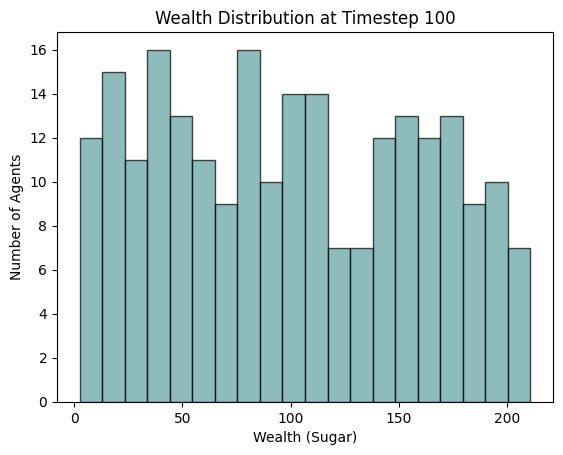

In [21]:
def plot_wealth_distribution(env, timestep):
    """Plots the wealth distribution of agents at a given timestep."""
    wealth = [agent.sugar for agent in env.agents]
    plt.hist(wealth, bins=20, color='cadetblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Wealth (Sugar)')
    plt.ylabel('Number of Agents')
    plt.title(f'Wealth Distribution at Timestep {timestep}')
    plt.show()

# Call this function at specific timesteps
plot_wealth_distribution(env, timestep=timesteps)

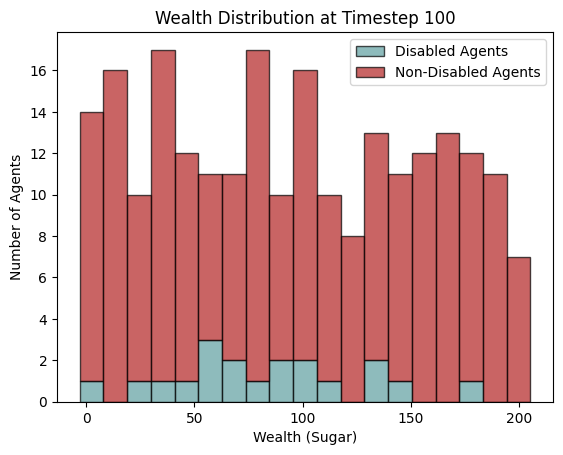

In [22]:
def plot_wealth_distribution_stacked(env, timestep):
    """Plots the wealth distribution of agents at a given timestep,
    differentiating between disabled and non-disabled agents."""

    # Separate wealth values by disability status
    disabled_wealth = [agent.sugar for agent in env.agents if agent.disability]
    non_disabled_wealth = [agent.sugar for agent in env.agents if not agent.disability]

    # Define bins for the histogram
    bins = np.linspace(min(disabled_wealth + non_disabled_wealth, default=0),
                        max(disabled_wealth + non_disabled_wealth, default=1),
                        20)

    # Compute histogram data for both groups
    disabled_hist, _ = np.histogram(disabled_wealth, bins=bins)
    non_disabled_hist, _ = np.histogram(non_disabled_wealth, bins=bins)

    # Plot a stacked bar chart
    bar_width = bins[1] - bins[0]
    plt.bar(bins[:-1], disabled_hist, width=bar_width, color='cadetblue', alpha=0.7, label='Disabled Agents',  edgecolor='black')
    plt.bar(bins[:-1], non_disabled_hist, width=bar_width, bottom=disabled_hist, color='firebrick', alpha=0.7, label='Non-Disabled Agents',  edgecolor='black')

    # Add labels, title, and legend
    plt.xlabel('Wealth (Sugar)')
    plt.ylabel('Number of Agents')
    plt.title(f'Wealth Distribution at Timestep {timestep}')
    plt.legend()
    plt.show()

plot_wealth_distribution_stacked(env, timestep=timesteps)

# Emergent behaviour and Feedback Loops

Gini Coefficient for Sugar Distribution: 0.3405
Correlations:
                  Sugar  Welfare Count  Disability
Sugar          1.000000      -0.193566   -0.064299
Welfare Count -0.193566       1.000000    0.917953
Disability    -0.064299       0.917953    1.000000


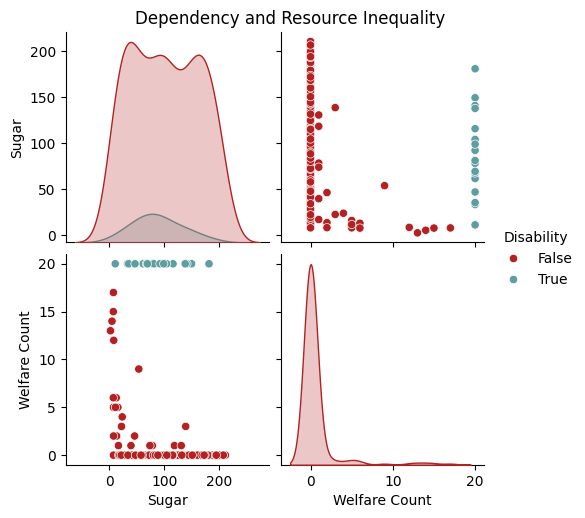

In [23]:
def analyse_emergent_behavior(data):
    # Compute Gini coefficient for sugar distribution
    gini = gini_coefficient(data['Sugar'].values)
    print(f"Gini Coefficient for Sugar Distribution: {gini:.4f}")

    # Correlation analysis
    correlations = data[['Sugar', 'Welfare Count', 'Disability']].corr()
    print("Correlations:")
    print(correlations)

    # Pairplot visualization for dependency clustering
    sns.pairplot(data[['Sugar', 'Welfare Count', 'Disability']], hue='Disability', palette=['firebrick','cadetblue'])
    plt.suptitle('Dependency and Resource Inequality', y=1.02)
    plt.show()

analyse_emergent_behavior(final_agents_df)

# Feedback Loops

Negative Feedback:
- Welfare redistributes resources, attempting to stabilize disparities but potentially creating dependency cycles.

Positive Feedback:
- improved welfare benefits reduce poverty, which in turn decreases social welfare expenditures, reinforcing policy success

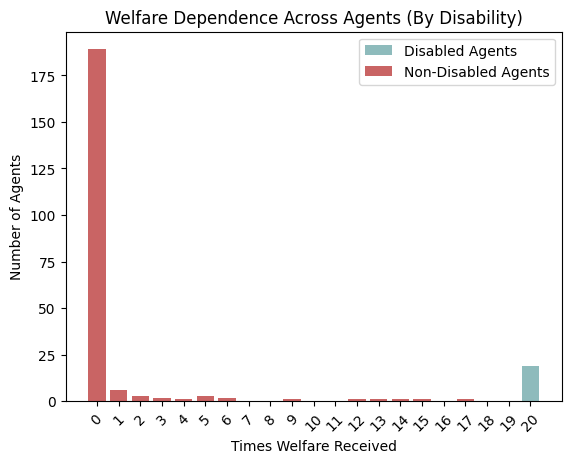

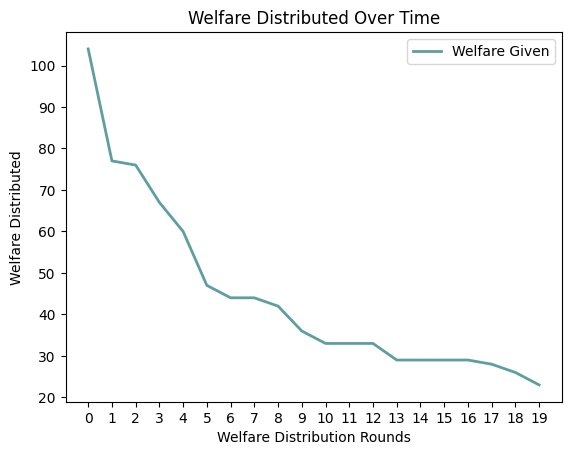

In [24]:
def plot_welfare_dependence(env):
    """Plot the number of times agents received welfare, categorized by disability status."""
    # Separate welfare counts by disability status
    disabled_counts = [agent.welfare_count for agent in env.agents if agent.disability]
    non_disabled_counts = [agent.welfare_count for agent in env.agents if not agent.disability]

    # Compute histogram data for both groups
    bins = range(0, max(max(disabled_counts, default=0), max(non_disabled_counts, default=0)) + 2)
    disabled_hist, _ = np.histogram(disabled_counts, bins=bins)
    non_disabled_hist, _ = np.histogram(non_disabled_counts, bins=bins)

    # Plot a stacked bar chart
    bar_width = 0.8
    x = np.arange(len(bins) - 1)
    plt.bar(x, disabled_hist, width=bar_width, label='Disabled Agents', color='cadetblue', alpha=0.7)
    plt.bar(x, non_disabled_hist, width=bar_width, label='Non-Disabled Agents', bottom=disabled_hist, color='firebrick', alpha=0.7)

    # Add labels and title
    plt.xlabel('Times Welfare Received')
    plt.ylabel('Number of Agents')
    plt.title('Welfare Dependence Across Agents (By Disability)')
    plt.xticks(x, bins[:-1], rotation=45)
    plt.legend()
    plt.show()

def plot_welfare_given(env):
    """Plot the welfare distributed at each step."""
    plt.plot(env.total_welfare_given, label='Welfare Given', color='cadetblue')
    plt.xlabel('Welfare Distribution Rounds')
    plt.ylabel('Welfare Distributed')
    plt.title('Welfare Distributed Over Time')
    plt.legend()
    plt.xticks(range(len(env.total_welfare_given)))  # Ensure x-axis has whole integers
    plt.show()

plot_welfare_dependence(env)
plot_welfare_given(env)

# Nonlinearity
Increasing funding for welfare programs might initially reduce poverty significantly, but beyond a certain threshold, the impact diminishes, illustrating diminishing returns.
Implementing universal basic income might sharply reduce inequality in the short term, but long-term effects depend on factors like inflation and economic growth.

Gini Coefficient's Role: Reducing the Gini coefficient through welfare policies may exhibit nonlinear effects. For instance, initial redistribution efforts might have a significant impact, but further efforts might yield diminishing returns due to structural barriers.

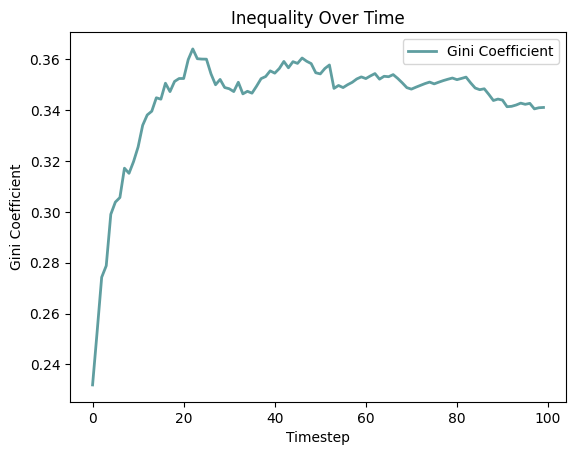

In [25]:
plt.plot(range(len(env.gini_seq)), env.gini_seq, label='Gini Coefficient', color='cadetblue')
plt.xlabel('Timestep')
plt.ylabel('Gini Coefficient')
plt.title('Inequality Over Time')
plt.legend()
plt.show()


# Interconnectedness
Social welfare policies involve various actors and systems, such as governments, non-profits, private companies, and individuals. Decisions in one area, like unemployment benefits, affect others, such as healthcare access or housing stability. These interdependencies mean small changes in one policy can ripple across the system, creating unanticipated outcomes.

- compare outcomes for simulations which differ in amount of welfare/timing of welfare

In [26]:
def run_simulations(n, params_list):
    """Run multiple simulations with different welfare parameters."""
    results = []
    for params in params_list:
        env = Sugarscape(n, **params)
        for _ in range(100):  # Run for 100 timesteps
            env.step()
        results.append(env)
    return results

def compare_welfare_policies(simulations, metric):
    """Compare outcomes for simulations with different welfare policies."""
    for i, env in enumerate(simulations):
        if metric == 'gini':
            plt.plot(env.gini_seq, label=f'Simulation {i+1}', color=palette[i %len(palette)])
        elif metric == 'survival':
            plt.plot(env.agent_count_seq, label=f'Simulation {i+1}', color=palette[i % len(palette)])
    plt.xlabel('Timestep')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of {metric.capitalize()} Across Simulations')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True)
    plt.show()


In [27]:
params1 = {'welfare_amount': 1, 'welfare_timestep': 2}
params2 = {'welfare_amount': 2, 'welfare_timestep': 2}
params3 = {'welfare_amount': 10, 'welfare_timestep': 2}
params4 = {'welfare_amount': 1, 'welfare_timestep': 3}
params5 = {'welfare_amount': 2, 'welfare_timestep': 3}
params6 = {'welfare_amount': 10, 'welfare_timestep': 3}
params7 = {'welfare_amount': 1, 'welfare_timestep': 10}
params8 = {'welfare_amount': 2, 'welfare_timestep': 10}
params9 = {'welfare_amount': 10, 'welfare_timestep': 10}

In [28]:
sims = run_simulations(n=50, params_list=[params1, params2, params3, params4, params5, params6, params7, params8, params9])

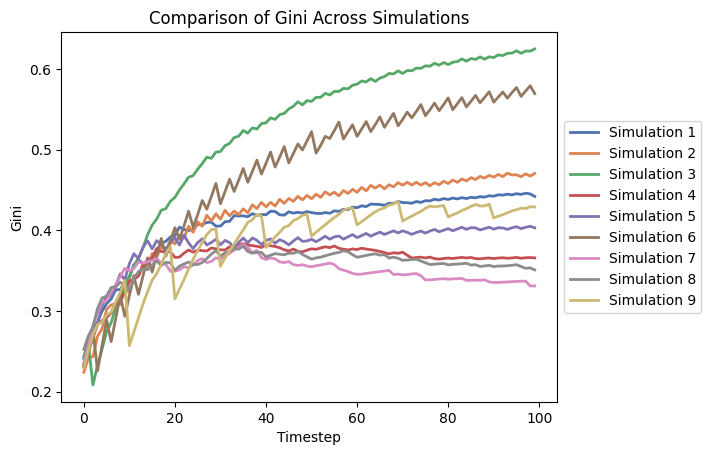

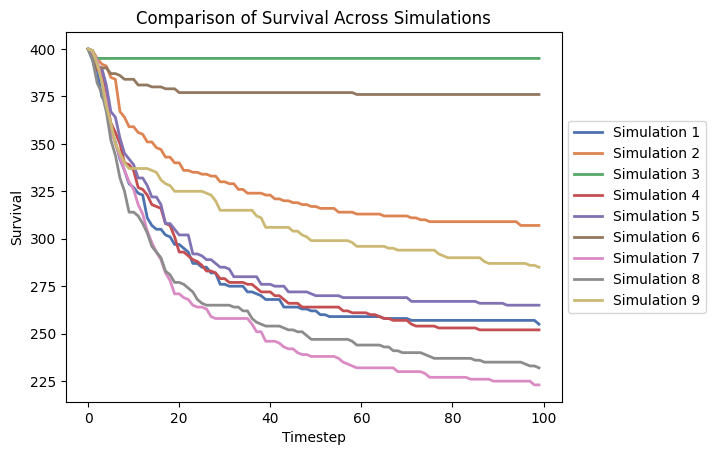

In [29]:
compare_welfare_policies(sims, metric='gini')
compare_welfare_policies(sims, metric='survival')

# Unintended consequences
Compare simulations with and without welfare to identify unintended consequences.
Highlight examples where policy interventions produced counterintuitive outcomes (e.g., increased clustering or resource hoarding).

In [30]:
with_welfare = {'welfare_amount': 2, 'welfare_timestep': 5}
without_welfare = {'welfare_amount': 0, 'welfare_timestep': 5}

sims_welfare = run_simulations(n=50, params_list=[with_welfare, without_welfare])

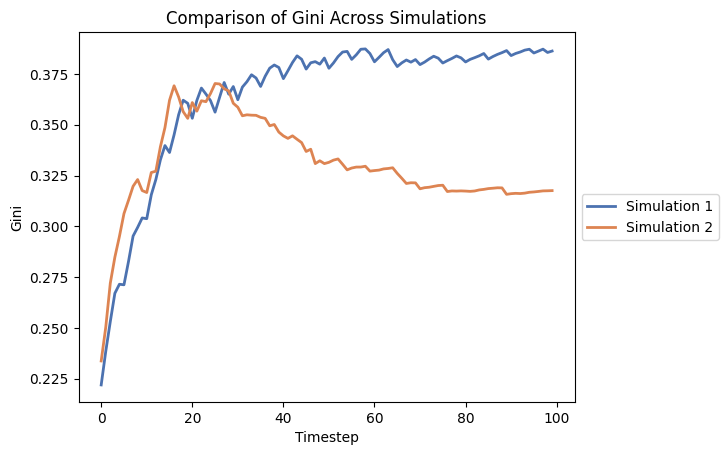

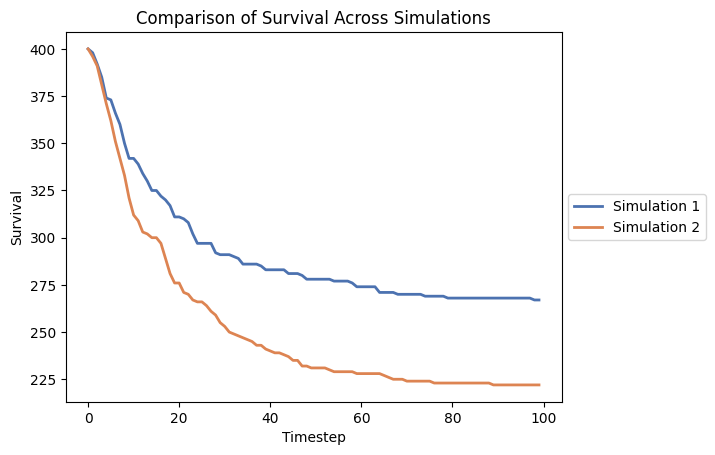

In [31]:
compare_welfare_policies(sims_welfare, metric='gini')
compare_welfare_policies(sims_welfare, metric='survival')

# Heterogeneity and Interdependence

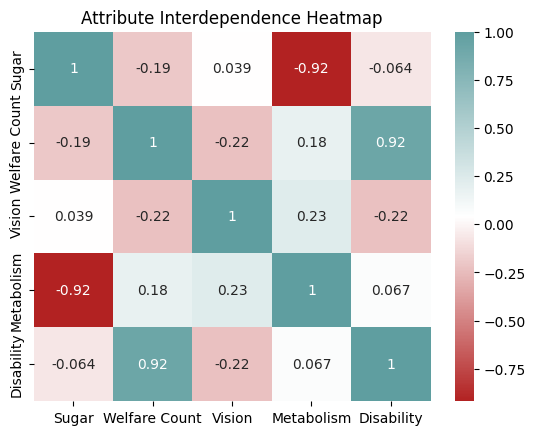

In [32]:
def show_correlation_matrix(data):
    # Correlation matrix for interdependence of attributes
    attributes = ['Sugar', 'Welfare Count', 'Vision', 'Metabolism', 'Disability']
    correlation_matrix = data[attributes].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap=diverge_cmap)
    plt.title('Attribute Interdependence Heatmap')
    plt.show()

show_correlation_matrix(final_agents_df)